In [1]:
this_notebook_name = "SagittalSpineSegmentationStudy"

# Update this folder name for your computer

local_data_folder = r"d:\Data\SagittalSpineSegmentationStudy"
overwrite_existing_data_files = False

# All results and output will be archived with this timestamp

import datetime
save_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print("Save timestamp: {}".format(save_timestamp))

# Learning parameters

import numpy as np

ultrasound_size = 128
num_classes = 2
num_epochs = 40
batch_size = 48
max_learning_rate = 0.02
min_learning_rate = 0.00001
regularization_rate = 0.0001
filter_multiplier = 10
WCE_weights = np.array([0.2, 0.8])
learning_rate_decay = (max_learning_rate - min_learning_rate) / num_epochs

# Training data augmentation parameters

max_shift_factor = 0.12
max_rotation_angle = 10
max_zoom_factor = 1.1
min_zoom_factor = 0.8

# Evaluation parameters

acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

limit_validation_rounds = -1

# Uncomment for faster debugging

# roc_thresholds = [0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
# limit_validation_rounds = 2
# num_epochs = 1

Save timestamp: 2019-11-19_15-56-35


In [2]:
import os
from random import sample

from ipywidgets import IntProgress
from IPython.display import display, HTML

import girder_client
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import ultrasound_batch_generator as generator
import sagittal_spine_segmentation_unet as unet
import evaluation_metrics

Using TensorFlow backend.


In [3]:
# Define what data to download

girder_api_url = "https://pocus.cs.queensu.ca/api/v1"

training_ultrasound_ids = [
    "5da9e5c0d9e6a3be02d012b4",
    "5da9e5c7d9e6a3be02d012c6",
    "5da9e5c2d9e6a3be02d012b7",
    "5da9e5c3d9e6a3be02d012ba",
    "5da9e5c8d9e6a3be02d012c9",
    "5da9e5c5d9e6a3be02d012c0",
    "5da9e5c6d9e6a3be02d012c3",
    "5da9e5c4d9e6a3be02d012bd"
]

training_ultrasound_filenames = [
    "q000_ultrasound.npy",
    "q001_ultrasound.npy",
    "q002_ultrasound.npy",
    "q003_ultrasound.npy",
    "q004_ultrasound.npy",
    "q005_ultrasound.npy",
    "q006_ultrasound.npy",
    "q007_ultrasound.npy"
]

training_segmentation_ids = [
    "5da9e5c8d9e6a3be02d012cc",
    "5da9e5ccd9e6a3be02d012de",
    "5da9e5c9d9e6a3be02d012cf",
    "5da9e5cad9e6a3be02d012d2",
    "5da9e5cdd9e6a3be02d012e1",
    "5da9e5cbd9e6a3be02d012d8",
    "5da9e5cbd9e6a3be02d012db",
    "5da9e5cad9e6a3be02d012d5"
]

training_segmentation_filenames = [
    "q000_segmentation.npy",
    "q001_segmentation.npy",
    "q002_segmentation.npy",
    "q003_segmentation.npy",
    "q004_segmentation.npy",
    "q005_segmentation.npy",
    "q006_segmentation.npy",
    "q007_segmentation.npy"
]

In [4]:
# These subfolders will be created/populated in the data folder

data_arrays_folder    = "DataArrays"
notebooks_save_folder = "SavedNotebooks"
results_save_folder   = "SavedResults"
models_save_folder    = "SavedModels"
val_data_folder       = "PredictionsValidation"

data_arrays_fullpath = os.path.join(local_data_folder, data_arrays_folder)
notebooks_save_fullpath = os.path.join(local_data_folder, notebooks_save_folder)
results_save_fullpath = os.path.join(local_data_folder, results_save_folder)
models_save_fullpath = os.path.join(local_data_folder, models_save_folder)
val_data_fullpath = os.path.join(local_data_folder, val_data_folder)

if not os.path.exists(data_arrays_fullpath):
    os.makedirs(data_arrays_fullpath)
    print("Created folder: {}".format(data_arrays_fullpath))

if not os.path.exists(notebooks_save_fullpath):
    os.makedirs(notebooks_save_fullpath)
    print("Created folder: {}".format(notebooks_save_fullpath))

if not os.path.exists(results_save_fullpath):
    os.makedirs(results_save_fullpath)
    print("Created folder: {}".format(results_save_fullpath))

if not os.path.exists(models_save_fullpath):
    os.makedirs(models_save_fullpath)
    print("Created folder: {}".format(models_save_fullpath))

if not os.path.exists(val_data_fullpath):
    os.makedirs(val_data_fullpath)
    print("Created folder: {}".format(val_data_fullpath))

In [5]:
# Download data from Girder

time_download_start = datetime.datetime.now()

print("Downloading training files ...")

# Setting up number of validation rounds

n_files = len(training_ultrasound_ids)
if limit_validation_rounds > 0:
    num_validation_rounds = min(n_files, limit_validation_rounds)
else:
    num_validation_rounds = n_files

# Preparing progress bar

f = IntProgress(min=0, max=n_files*2)
display(f)

# Downloading files

gclient = girder_client.GirderClient(apiUrl=girder_api_url)

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    if not os.path.exists(ultrasound_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(ultrasound_fullname))
        gclient.downloadFile(training_ultrasound_ids[i], ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])
    if not os.path.exists(segmentation_fullname) or overwrite_existing_data_files:
        print("Downloading {}...".format(segmentation_fullname))
        gclient.downloadFile(training_segmentation_ids[i], segmentation_fullname)
    f.value = i * 2 + 2

time_download_stop = datetime.datetime.now()
print("\nTotal download time: {}".format(time_download_stop - time_download_start))

IntProgress(value=0, max=16)


Total download time: 0:00:00.014938


In [6]:
# Read data into numpy arrays

ultrasound_arrays = []
segmentation_arrays = []

f = IntProgress(min=0, max=n_files * 2)
display(f)

time_start = datetime.datetime.now()

for i in range(n_files):
    ultrasound_fullname = os.path.join(data_arrays_fullpath, training_ultrasound_filenames[i])
    segmentation_fullname = os.path.join(data_arrays_fullpath, training_segmentation_filenames[i])

    ultrasound_data = np.load(ultrasound_fullname)
    f.value = i * 2 + 1
    
    segmentation_data = np.load(segmentation_fullname)
    f.value = i * 2 + 2
    
    ultrasound_arrays.append(ultrasound_data)
    segmentation_arrays.append(segmentation_data)

time_stop = datetime.datetime.now()
print("\nTotal time to load from files: {}".format(time_stop - time_start))

IntProgress(value=0, max=16)


Total time to load from files: 0:00:00.507181


Timestamp for saved files: 2019-11-19_15-56-35

Training parameters
Number of epochs:    40
Step size maximum:   0.02
Step size decay:     0.00049975
Batch size:          48
Regularization rate: 0.0001

Saving validation predictions in: d:\Data\SagittalSpineSegmentationStudy\PredictionsValidation
Saving models in:                 d:\Data\SagittalSpineSegmentationStudy\SavedModels

*** Leave-one-out round # 0

Training on 2767 images, validating on 523 images...


e:\dlenv\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



Metrics at the end of training
  val_acc:       0.9961077570915222
  val loss:      0.0028242620650187392
  Training time: 0:05:18.306914

Total round time:  0:05:37.605909


*** Leave-one-out round # 1

Training on 2935 images, validating on 355 images...

Metrics at the end of training
  val_acc:       0.9979798088611012
  val loss:      0.00348652238485364
  Training time: 0:05:45.211780

Total round time:  0:06:00.014183


*** Leave-one-out round # 2

Training on 2813 images, validating on 477 images...

Metrics at the end of training
  val_acc:       0.9954105855533911
  val loss:      0.002504609119580508
  Training time: 0:05:29.041582

Total round time:  0:05:48.342666


*** Leave-one-out round # 3

Training on 2837 images, validating on 453 images...

Metrics at the end of training
  val_acc:       0.996237922188462
  val loss:      0.004785142980812006
  Training time: 0:05:35.392227

Total round time:  0:05:54.754828


*** Leave-one-out round # 4

Training on 3001 images, v

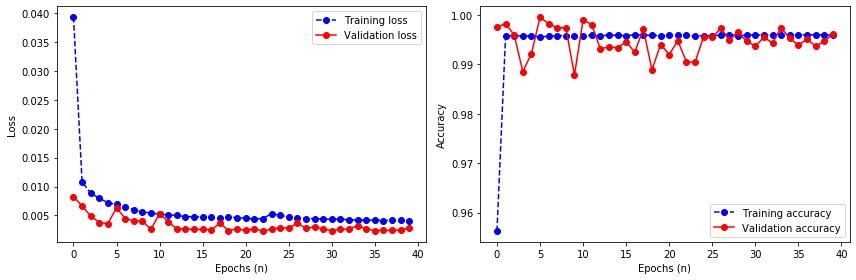

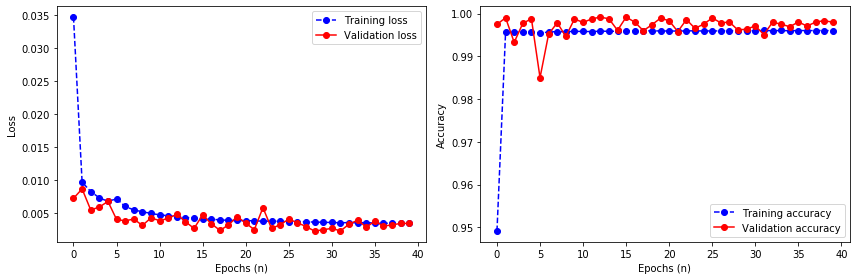

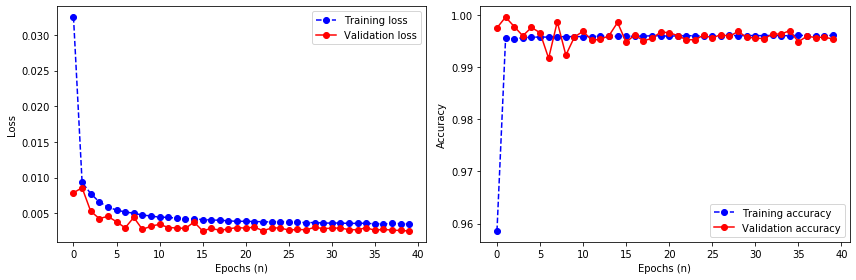

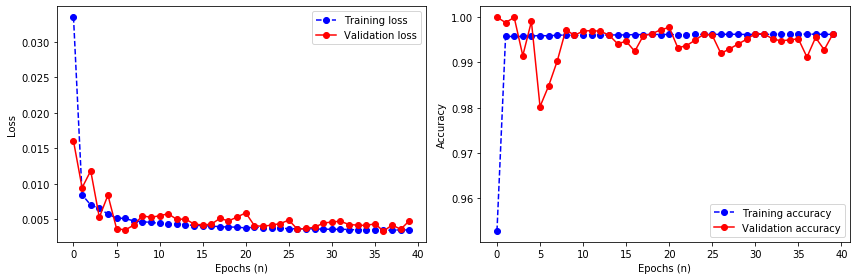

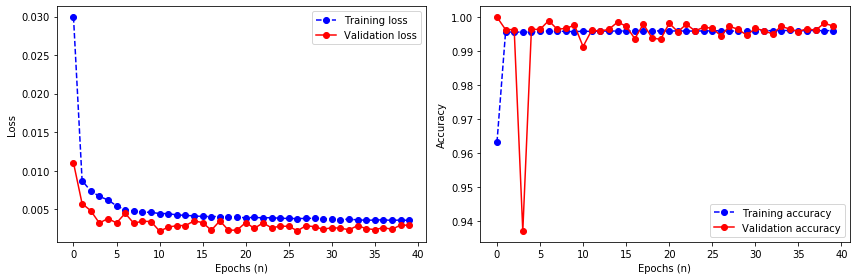

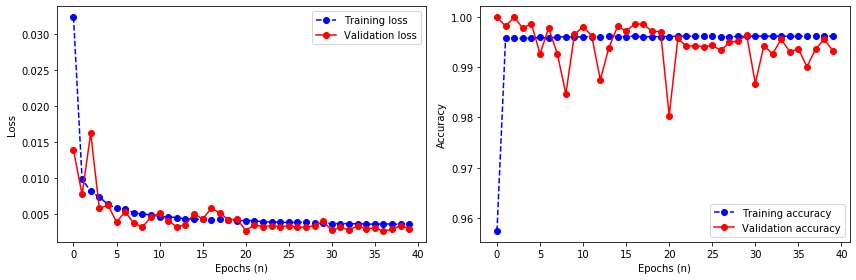

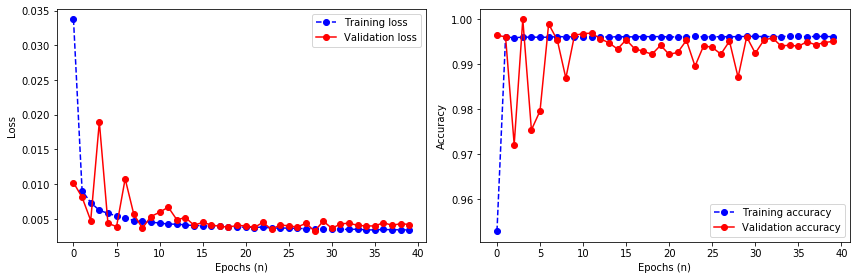

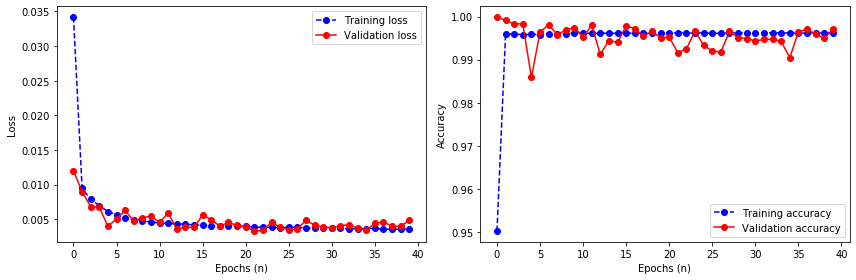

In [7]:
# Print training parameters, to archive them together with the notebook output.

time_sequence_start = datetime.datetime.now()

print("Timestamp for saved files: {}".format(save_timestamp))
print("\nTraining parameters")
print("Number of epochs:    {}".format(num_epochs))
print("Step size maximum:   {}".format(max_learning_rate))
print("Step size decay:     {}".format(learning_rate_decay))
print("Batch size:          {}".format(batch_size))
print("Regularization rate: {}".format(regularization_rate))
print("")
print("Saving validation predictions in: {}".format(val_data_fullpath))
print("Saving models in:                 {}".format(models_save_fullpath))

# ROC data will be saved in these containers

val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
val_aurocs          = np.zeros(num_validation_rounds)
val_best_thresholds = np.zeros(num_validation_rounds)

# Perform validation rounds

for i in range(num_validation_rounds):
    
    # Prepare data arrays
    
    train_ultrasound_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    train_segmentation_data = np.zeros(
        [0, ultrasound_arrays[0].shape[1], ultrasound_arrays[0].shape[2], ultrasound_arrays[0].shape[3]])
    
    val_ultrasound_data = ultrasound_arrays[i]
    val_segmentation_data = segmentation_arrays[i]
    val_ultrasound_filename = training_ultrasound_filenames[i]
    
    for train_index in range(n_files):
        if train_index != i:
            train_ultrasound_data = np.concatenate((train_ultrasound_data, ultrasound_arrays[train_index]))
            train_segmentation_data = np.concatenate((train_segmentation_data, segmentation_arrays[train_index]))
    
    n_train = train_ultrasound_data.shape[0]
    n_val = val_ultrasound_data.shape[0]
    
    print("\n*** Leave-one-out round # {}".format(i))
    print("\nTraining on {} images, validating on {} images...".format(n_train, n_val))
    
    # Create and train model
    
    model = unet.sagittal_spine_unet(ultrasound_size, num_classes, filter_multiplier, regularization_rate)
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=max_learning_rate, decay=learning_rate_decay),
        loss=[unet.weighted_categorical_crossentropy(WCE_weights)],
        metrics=["accuracy", unet.dice_coef]
        # metrics=["accuracy"]
    )
        
    #model.summary()
        
    training_generator = generator.UltrasoundSegmentationBatchGenerator(
        train_ultrasound_data,
        train_segmentation_data[:, :, :, 0],
        batch_size,
        (ultrasound_size, ultrasound_size),
        max_shift_factor=max_shift_factor,
        min_zoom_factor=min_zoom_factor,
        max_zoom_factor=max_zoom_factor,
        max_rotation_angle=max_rotation_angle
    )
        
    training_time_start = datetime.datetime.now()
    
    training_log = model.fit_generator(
        training_generator,
        validation_data=(val_ultrasound_data, val_segmentation_data),
        epochs=num_epochs,
        verbose=0
    )
        
    training_time_stop = datetime.datetime.now()
    
    # Pring training log
    
    print("\nMetrics at the end of training")
    print("  val_acc:       {}".format(training_log.history['val_acc'][-1]))
    print("  val loss:      {}".format(training_log.history['val_loss'][-1]))
    # print("  val_dice:      {}".format(training_log.history['val_dice_coef'][-1]))
    print("  Training time: {}".format(training_time_stop-training_time_start))
    
    # Plot training loss and metrics
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    axes[0].plot(training_log.history['loss'], 'bo--')
    axes[0].plot(training_log.history['val_loss'], 'ro-')
    axes[0].set(xlabel='Epochs (n)', ylabel='Loss')
    axes[0].legend(['Training loss', 'Validation loss'])
    
    axes[1].plot(training_log.history['acc'], 'bo--')
    axes[1].plot(training_log.history['val_acc'], 'ro-')
    axes[1].set(xlabel='Epochs (n)', ylabel='Accuracy')
    axes[1].legend(['Training accuracy', 'Validation accuracy'])
    
    fig.tight_layout()
    
    # Predict on validation data
    
    y_pred_val  = model.predict(val_ultrasound_data)
    
    # Saving predictions for further evaluation
    
    filename_noext, extension = os.path.splitext(val_ultrasound_filename)
    val_prediction_filename = save_timestamp + "_prediction_" + filename_noext + ".npy"
    val_prediction_fullname = os.path.join(val_data_fullpath, val_prediction_filename)
    np.save(val_prediction_fullname, y_pred_val)
    
    # Archive trained model with unique filename based on notebook name and timestamp
    
    model_file_name = this_notebook_name + "_model-" + str(i) + "_" + save_timestamp + ".h5"
    model_fullname = os.path.join(models_save_fullpath, model_file_name)
    model.save(model_fullname)
    
    # Validation results
    
    vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
        roc_thresholds, y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_fuzzy_metrics[i] = evaluation_metrics.compute_evaluation_metrics(
        y_pred_val, val_segmentation_data, acceptable_margin_mm, mm_per_pixel)
    
    val_best_metrics[i]    = vali_metrics_dicts[vali_best_threshold_index]
    val_aurocs[i]          = vali_area
    val_best_thresholds[i] = roc_thresholds[vali_best_threshold_index]
    
    # Printing total time of this validation round
    
    print("\nTotal round time:  {}".format(datetime.datetime.now() - training_time_start))
    print("")


time_sequence_stop = datetime.datetime.now()

print("\nTotal training time:   {}".format(time_sequence_stop - time_sequence_start))


In [8]:
# Arrange results in tables

metric_labels = [
    "AUROC",
    "best thresh",
    "best TP",
    "best FP",
    "best recall",
    "best precis",
    "fuzzy recall",
    "fuzzy precis",
    "fuzzy Fscore"
]

results_labels = []

for label in metric_labels:
    results_labels.append("Vali " + label)

results_df = pd.DataFrame(columns = results_labels)

for i in range(num_validation_rounds):
    results_df.loc[i] = [
        val_aurocs[i],
        val_best_thresholds[i],
        val_best_metrics[i][evaluation_metrics.TRUE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.FALSE_POSITIVE_RATE],
        val_best_metrics[i][evaluation_metrics.RECALL],
        val_best_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.RECALL],
        val_fuzzy_metrics[i][evaluation_metrics.PRECISION],
        val_fuzzy_metrics[i][evaluation_metrics.FSCORE]
    ]

display(results_df)

print("\nAverages")

results_means_df = results_df.mean()
display(results_means_df)

,Vali AUROC,Vali best thresh,Vali best TP,Vali best FP,Vali best recall,Vali best precis,Vali fuzzy recall,Vali fuzzy precis,Vali fuzzy Fscore
0,0.496546,0.040,0.475771,0.018540,0.475771,0.227250,0.427648,0.400956,0.413872
1,0.492706,0.008,0.475289,0.027845,0.475289,0.152566,0.304165,0.440526,0.359861
2,0.498350,0.400,0.472475,0.002717,0.472475,0.562744,0.463700,0.391144,0.424342
3,0.494263,0.010,0.482194,0.027069,0.482194,0.220266,0.366165,0.503911,0.424134
4,0.495588,0.010,0.485513,0.025879,0.485513,0.166761,0.366967,0.425812,0.394206
5,0.499132,0.600,0.524392,0.001463,0.524392,0.701835,0.501156,0.394155,0.441261
6,0.495447,0.020,0.479772,0.025042,0.479772,0.238716,0.408637,0.458404,0.432092
7,0.495405,0.010,0.485195,0.026095,0.485195,0.238234,0.330922,0.543017,0.411233



Averages


Vali AUROC           0.495930
Vali best thresh     0.137250
Vali best TP         0.485075
Vali best FP         0.019331
Vali best recall     0.485075
Vali best precis     0.313547
Vali fuzzy recall    0.396170
Vali fuzzy precis    0.444740
Vali fuzzy Fscore    0.412625
dtype: float64

In [9]:
# Save results table

csv_filename = this_notebook_name + "_" + save_timestamp + ".csv"
csv_fullname = os.path.join(results_save_fullpath, csv_filename)
results_df.to_csv(csv_fullname)

print("Results saved to: {}".format(csv_fullname))

Results saved to: d:\Data\SagittalSpineSegmentationStudy\SavedResults\SagittalSpineSegmentationStudy_2019-11-19_15-56-35.csv


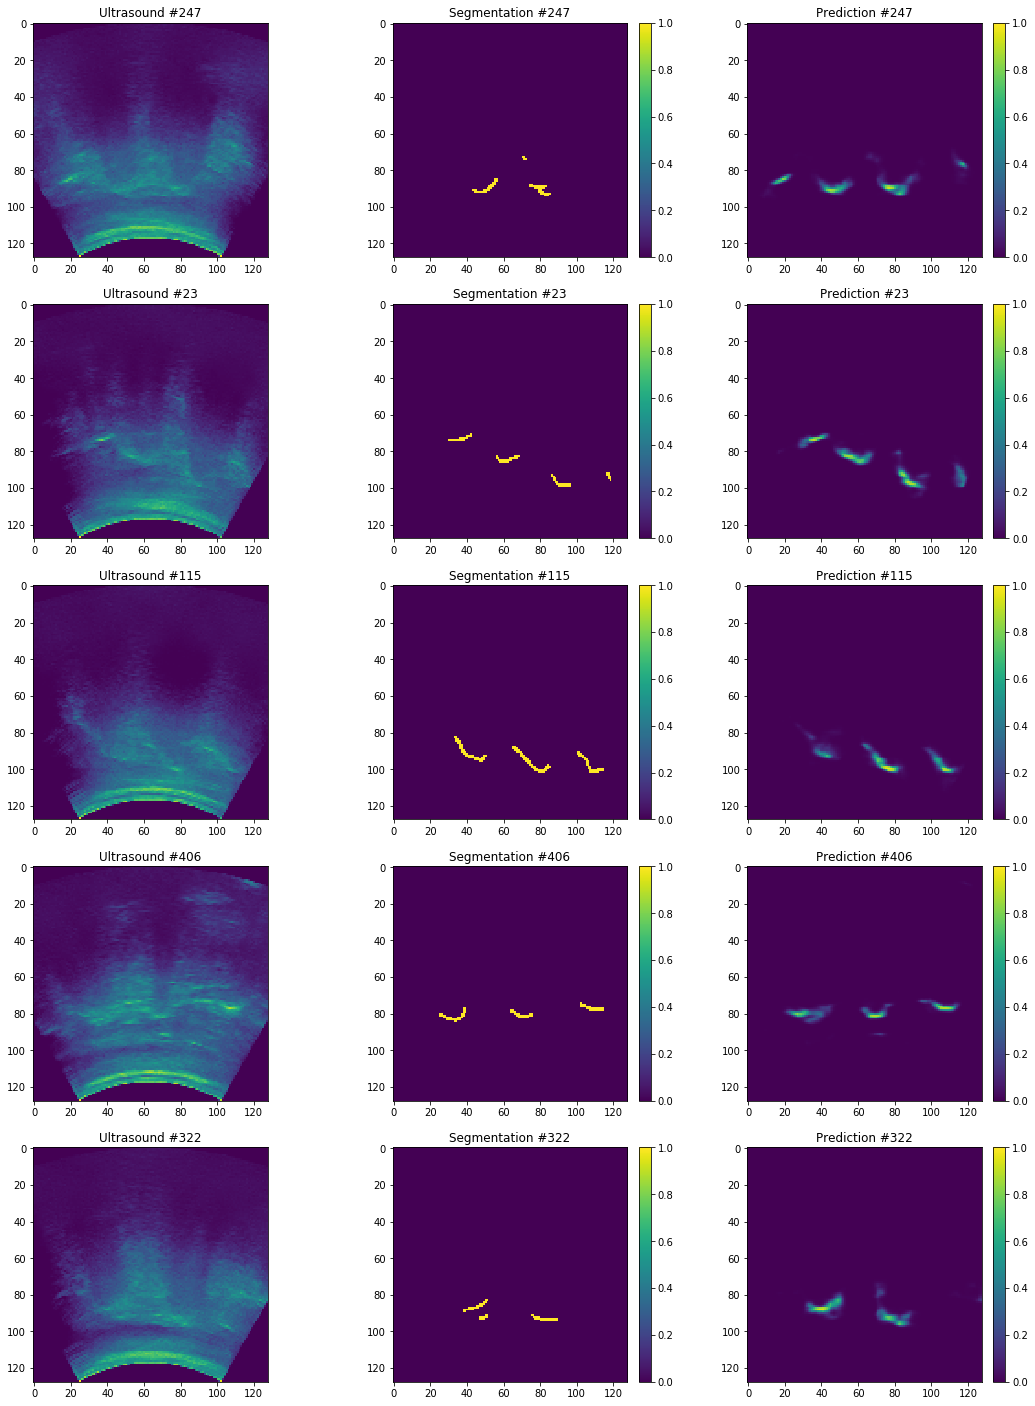

In [10]:
# Display sample results

num_vali = val_ultrasound_data.shape[0]
num_show = 5

indices = [i for i in range(num_vali)]
sample_indices = sample(indices, num_show)

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(val_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(val_segmentation_data[sample_indices[i], :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(y_pred_val[sample_indices[i], :, :, 1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

In [11]:
# Save notebook so all output is archived by the next cell

from IPython.display import Javascript
script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
Javascript(script)

<IPython.core.display.Javascript object>

In [12]:
# Export HTML copy of this notebook

notebook_file_name = this_notebook_name + "_" + save_timestamp + ".html"
notebook_fullname = os.path.join(notebooks_save_fullpath, notebook_file_name)

os.system("jupyter nbconvert --to html " + this_notebook_name + " --output " + notebook_fullname)
print("Notebook saved to: {}".format(notebook_fullname))

Notebook saved to: d:\Data\SagittalSpineSegmentationStudy\SavedNotebooks\SagittalSpineSegmentationStudy_2019-11-19_15-56-35.html
